In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import re

In [6]:
# Charger les fichiers de positions. Puis 1) les nettoyer. 2) Convertir en fréquences. 3) resynchroniser avec le son.

In [286]:
class Mapping(object):
    """
    
    """
    def __init__(self, width, n_freq, mid, octave):
        """
        Construction d'un objet de Mapping.
        :param width: Largeur de l'image en pixels. 
        :param n_freq: Nombre de fréquences.
        :param mid: Fréquence du milieu.
        :param octave: Nombre d'octaves.
        """
        self.bandwidth = width / (n_freq - 1)
        self.half_bandwidth = self.bandwidth // 2
        self.width = width
        self.mid = mid
        self.o = octave
        self.m_numFrequency = n_freq
        self._lut_indices = np.zeros(self.width, dtype=int)
        self.tones = np.zeros(n_freq)
        self._lut_tones = np.zeros(self.width)
        self._build_lut()

    def _build_lut(self):
        """
        Construit la "look-up table" des indices du mapping et également la LUT des fréquences.
        """
        
        def mapping(mid, n, o):
            _t = np.zeros(n)
            m_idx = n // 2
            _t[m_idx] = 0
            s = o / n
            _t[:m_idx] = np.arange((- n // 2) + 1, 0)
            _t[m_idx + 1:] = np.arange(1, n // 2 + 1)
            _t = np.round(mid * np.power(2, _t * s))
            return _t
        
        def func(position):
            if position < self.half_bandwidth:
                index = 0
            elif position > (self.width - self.half_bandwidth):
                index = self.m_numFrequency - 1
            else:
                index = position - self.half_bandwidth
                index //= self.bandwidth
                index += 1
            return int(index)
        
        def func_fill_tones(position, tones):
            return tones[func(position)]
        
        self.tones = mapping(self.mid, self.m_numFrequency, 7.0)
        for i in range(self.width):
            self._lut_indices[i] = func(i)
            self._lut_tones[i] = func_fill_tones(i, self.tones)
            

    def get_start_stop(self, motion):
        """
        Renvoie les indices de départ et d'arrivée pour un mouvement donnée.
        """
        start = self._lut_indices[motion[0]]
        stop = self._lut_indices[motion[1]]
        return start, stop
    
    def convert_position(self, x):
        if not np.isnan(x) and x != -1:
            return self._lut_tones[int(x)]
        else:
            return -1
    
    def convert_to_frequency(self, motion):
        """
        Renvoie les fréquences correspondantes aux positions dans un vecteur.
        :param motion: 
        :return: 
        """
        t = np.zeros(len(motion), dtype=float)
        for i, _p in enumerate(motion):
            if not np.isnan(_p):
                t[i] = self._lut_tones[int(_p)]
            else:
                t[i] = np.nan
        return t

In [287]:
def clean_positions(positions):
    """
    Fonction de nettoyage des positions enregistrées au cours de l'expérience. Pour rappel, une valeur de -1, indique que le sujet n'a pas été détecté par le réseau de neurones.
    :param positions: 
    :return: 
    """
    y = np.where(positions == -1)[0]
    diff_y = np.diff(y)
    diff_y = np.vstack((np.arange(1, len(diff_y) + 1), diff_y)).T
    k = 0
    begin = 0
    for i, elt in diff_y:
        if elt != 1:
            positions[y[i - 1]] = positions[y[i - 1] + 1]
            positions[y[i]] = positions[y[i] - 1]
            if k != 0:
                end = y[i - 1]
                filler = np.full(shape=k, fill_value=positions[begin - 1])
                positions[begin:end] = filler
                k = 0
        else:
            if k == 0:
                begin = y[i - 1]
            k += 1
    remainder = np.where(positions == -1)[0]
    if len(remainder) != 0 and k != 0:
        pass

    return positions


def stack_positions_data(positions_files):
    """
    Retourne les vecteurs continus, et un np.ndarray des positons où il faudra recouper pour séparer à nouveau.
    :param positions_files: 
    :return: 
    """
    # Ici, il va falloir garder en mémoire la dimension exacte de chaque sous tableau.
    split_mem = np.zeros(len(positions_files) - 1, dtype=int)
    is_playback = list()
    playback_pattern = "positions_Playback_playback_0[0-9]"
    positions_vectors = list()
    start = 0
    for i, file in enumerate(positions_files):
        # Je connais les indices où sont les positions de playback.
        if re.search(playback_pattern, file):
            is_playback.append(i)
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(positions_files) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    cp = clean_positions(np.hstack(positions_vectors))
    cp = np.split(cp, split_mem)
    playback_positions_list = [cp[i] for i in is_playback]
    print(is_playback)
    return playback_positions_list


def stack_positions_data_tracking(positions_files):
    """
    Retourne les vecteurs continus, et un np.ndarray des positons où il faudra recouper pour séparer à nouveau.
    :param positions_files: 
    :return: 
    """
    # Ici, il va falloir garder en mémoire la dimension exacte de chaque sous tableau.
    split_mem = np.zeros(len(positions_files) - 1, dtype=int)
    is_playback = list()
    playback_pattern = "positions_Playback_tracking_0[0-9]"
    positions_vectors = list()
    start = 0
    for i, file in enumerate(positions_files):
        # Je connais les indices où sont les positions de playback.
        if re.search(playback_pattern, file):
            is_playback.append(i)
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(positions_files) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    # print(is_playback)
    cp = clean_positions(np.hstack(positions_vectors))
    cp = np.split(cp, split_mem)
    playback_positions_list = [cp[i] for i in is_playback]
    print(is_playback)
    return playback_positions_list
    
    
def detect_frequency_switch(vec, mapping):
    """
    Fonction qui a pour objectif de détecter les changements de fréquences.
    :param mapping:
    :param vec: 
    :return: 
    """
    # print(np.unique(vec))
    tone_vec = mapping.convert_to_frequency(vec)
    d = np.diff(tone_vec)
    idx = np.where(d != 0)[0] + 1
    switch = tone_vec[idx]
    return switch


def load_mock_tones_files(folder):
    return _load_tones(folder, "tracking_mock")


def load_playback_tones_files(folder):
    return _load_tones(folder, "playback")


def load_tracking_tones_files(folder):
    return _load_tones(folder, "tracking")


def load_warmup_tones_files(folder):
    return _load_tones(folder, "warmup")


def _load_tones(folder, type_of):
    glob_files = glob(os.path.join(folder, "tones", "*.bin"))
    pattern = f"{type_of}_0[0-9]"
    clean_files = list()
    for file in glob_files:
        if re.search(pattern, file):
            clean_files.append(file)
    files = ["" for _ in clean_files]
    for file in clean_files:
        match = re.search(rf'{type_of}_(\d+)', file)
        if match:
            value = int(match.group(1))
            p = np.fromfile(file, dtype=float)
            files[value] = p
    return files


def load_positions_file(folder):
    """
    Retourne une liste avec les fichiers des positions enregistrées au cours de l'expérience ordonnés.
    :param folder: Dossier de sauvegarde de l'expérience.
    :return: Une liste avec les noms de fichiers dans l'ordre chronologique.
    """
    # Pipeline : extraire tous les fichiers, les remettre dans l'ordre. Nettoyer, couper.
    # Extraire les fréquences du Mock.
    # Comparer la longueur, une fois les changements détectés. OK.
    pause_pattern = "positions_Pause_0[0-9]"
    playback_pattern = "positions_Playback_playback_0[0-9]"
    tracking_pattern = "positions_Playback_tracking_0[0-9]"
    warmup_pattern = "positions_Playback_warmup_0[0-9]"

    glob_files = glob(os.path.join(folder, "positions", "positions_*.bin"))
    types_pos_list = [list() for _ in range(4)]
    for file in glob_files:
        if re.search(pause_pattern, file):
            types_pos_list[0].append(file)
        elif re.search(warmup_pattern, file):
            types_pos_list[1].append(file)
        elif re.search(tracking_pattern, file):
            types_pos_list[2].append(file)
        elif re.search(playback_pattern, file):
            types_pos_list[3].append(file)
    
    out = ["" for _ in glob_files]
    
    for file_name in types_pos_list[0]:
        match = re.search(r'positions_Pause_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[0] = file_name
            else:
                out[-1] = file_name
                
    for file_name in types_pos_list[1]:
        match = re.search(r'positions_Playback_warmup_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[1] = file_name
            else:
                out[-2] = file_name
    idx = 2
    n_iter = len(types_pos_list[2])
    
    for i in range(n_iter):
        file_name = types_pos_list[2][i]
        match = re.search(r'positions_Playback_tracking_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            out[idx + value * 2] = file_name
        
        file_name = types_pos_list[3][i]
        match = re.search(r'positions_Playback_playback_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            out[idx + value * 2 + 1] = file_name
    return out


def test(folder):
    o = load_positions_file(folder)
    split_mem = np.zeros(len(o) - 1, dtype=int)
    positions_vectors = list()
    start = 0
    for i, file in enumerate(b):
        # Je connais les indices où sont les positions de playback.
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(o) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    cp = np.hstack(positions_vectors)
    cp = np.split(cp, split_mem)
    print(f"Length : {len(cp)}, {len(o)}, {len(positions_vectors)}")
    for i in range(len(cp)):
        print(len(cp[i]) == len(positions_vectors[i]))
    for i in range(len(cp)):
        print(cp[i] == positions_vectors[i])
        
    return 

In [298]:
def frequency_correction(folder):
    # C'est tout le pipeline de correction des fréquences.
    # 0. Créer le mapping
    mapping = Mapping(1920, 33, 2000., 7)
    # 1. Charger les "mock tones".
    mock_tones = load_mock_tones_files(folder)
    pb_tones = load_playback_tones_files(folder)
    tr_tones = load_tracking_tones_files(folder)
    positions = load_positions_file(folder)
    clean_pb_pos = stack_positions_data(positions)
    mock_corrected = [detect_frequency_switch(vec, mapping) for vec in clean_pb_pos]
    return mock_tones, positions, clean_pb_pos, mock_corrected, pb_tones, tr_tones

In [304]:
a, b, c, e, g, h = frequency_correction("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]


In [ ]:
for elt in range(len(a)):
    print(len(a[elt]), len(e[elt]))
    
# plt.plot(a[0])
tt = np.arange(len(g[0]) + len(e[0]) + len(g[1]) + len(e[1]))

plt.plot(tt[:len(g[0])], g[0])
_sum = len(g[0]) + len(e[0])
plt.plot(tt[len(g[0]): _sum], e[0])

plt.plot(tt[_sum:_sum + len(g[1])], g[1])
_sum += len(g[1])
plt.plot(tt[_sum:], e[1])

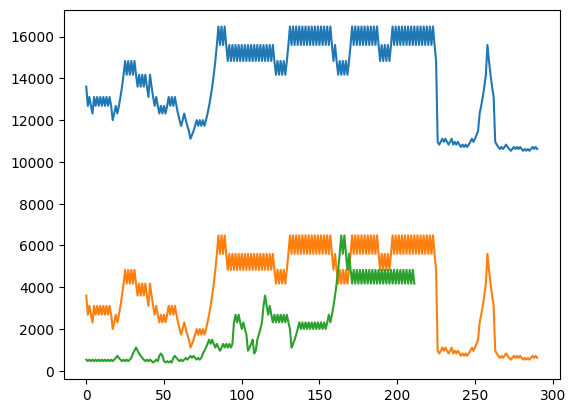

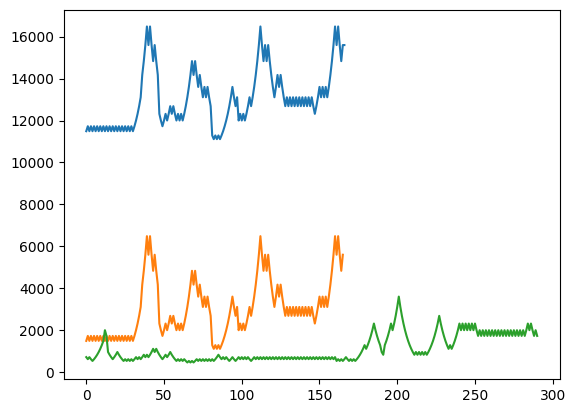

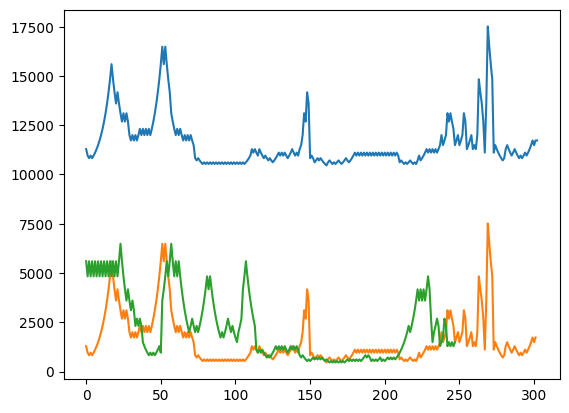

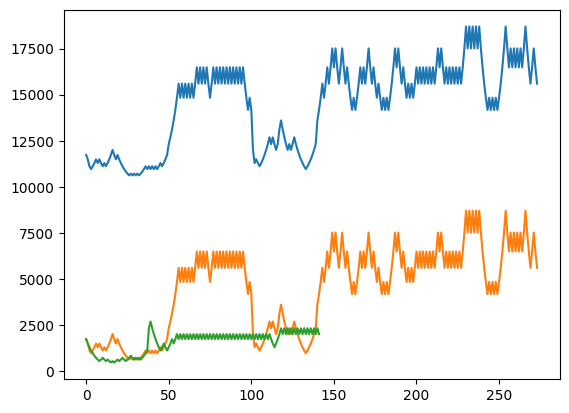

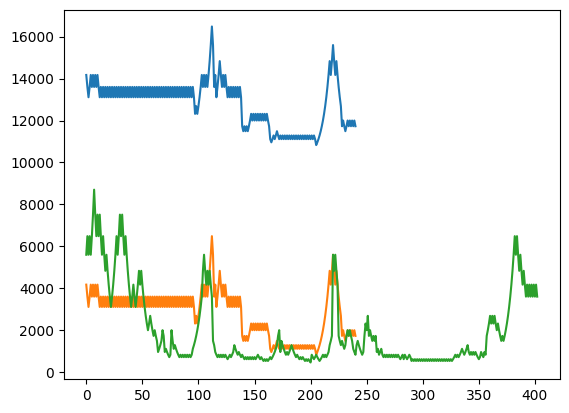

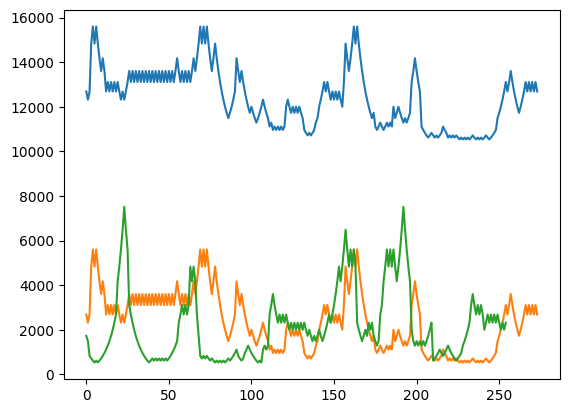

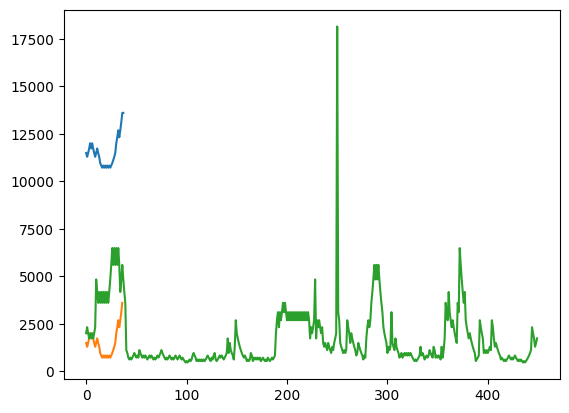

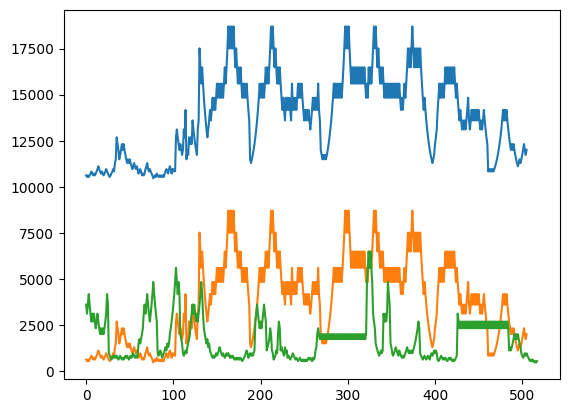

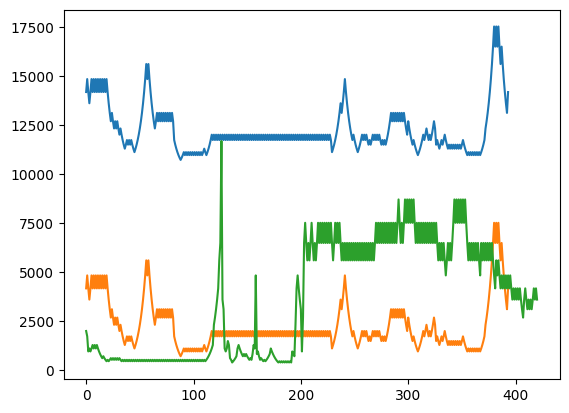

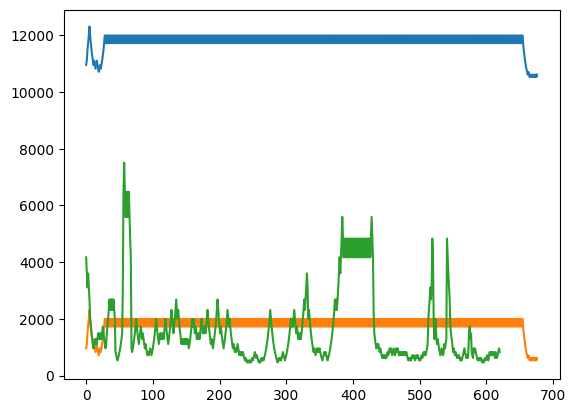

In [308]:
for l in range(len(a)):
    plt.plot(a[l] + 10000)
    plt.plot(e[l])
    plt.plot(g[l])
    plt.show()

<BarContainer object of 24 artists>

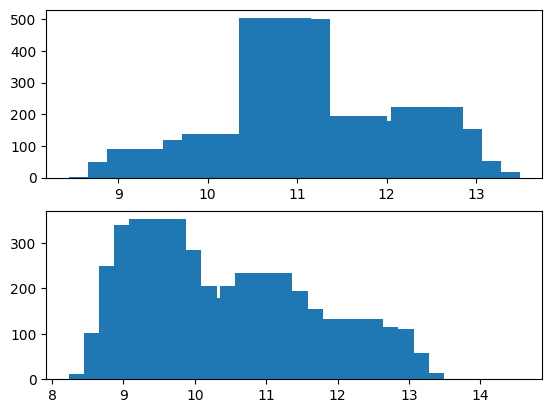

In [316]:
mck_total = np.hstack(a)
pb_total = np.hstack(g)
m = Mapping(1920, 33, 2000., 7)
un, counts = np.unique(mck_total, return_counts=True)
un_pb, counts_pb = np.unique(pb_total, return_counts=True)

fig, ax = plt.subplots(2, 1)
# h, _ = np.histogram(mck_total, m._lut_tones)
ax[0].bar(np.log2(un), counts)
ax[1].bar(np.log2(un_pb), counts_pb)
# plt.xticks()

In [296]:
def frequency_correction_2(folder):
    # C'est tout le pipeline de correction des fréquences.
    # 0. Créer le mapping
    mapping = Mapping(1920, 33, 2000., 7)
    # 1. Charger les "mock tones".
    mock_tones = load_mock_tones_files(folder)
    pb_tones = load_playback_tones_files(folder)
    tr_tones = load_tracking_tones_files(folder)
    positions = load_positions_file(folder)
    clean_pb_pos = stack_positions_data(positions)
    clean_tr_pos = stack_positions_data_tracking(positions)
    mock_corrected = [detect_frequency_switch(vec, mapping) for vec in clean_pb_pos]
    tr_test = [detect_frequency_switch(vec, mapping) for vec in clean_tr_pos]
    return clean_pb_pos, clean_tr_pos, mock_corrected, tr_test, pb_tones, tr_tones, positions

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]


ValueError: not enough values to unpack (expected 7, got 6)

291 291
167 166
303 302
274 274
241 241
274 274
38 37
506 506
394 394
677 677


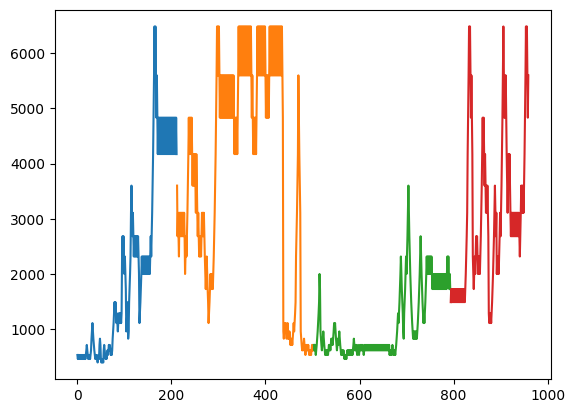

In [206]:
a = load_tracking_tones_files("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")
b = load_playback_tones_files("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")

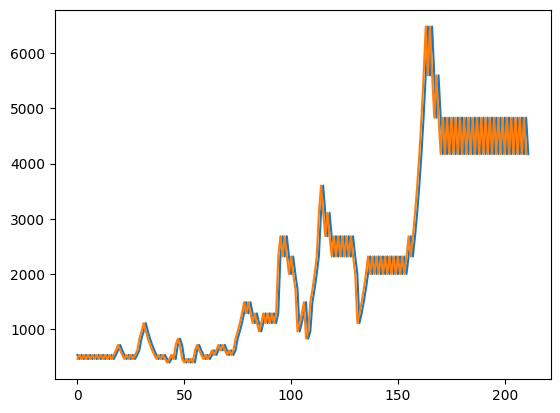

In [214]:
plt.plot(g[0])
plt.plot(h[0])

In [207]:
len(b)

10

In [290]:
a, b, c, e, g, h, q = frequency_correction_2("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


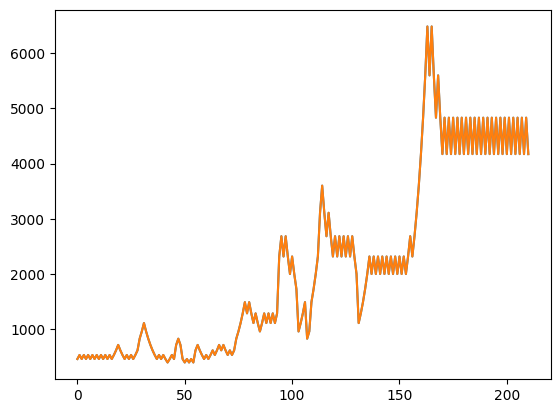

In [291]:
plt.plot(h[0])
# plt.plot(g[0])
plt.plot(e[0])

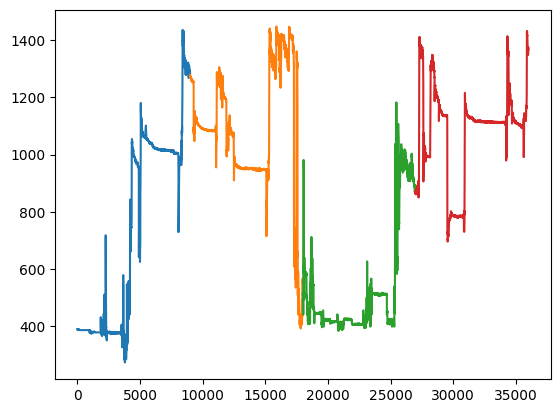

In [238]:
tt = np.arange(len(b[0]) + len(a[0]) + len(b[1]) + len(a[1]))
plt.plot(tt[:len(b[0])], b[0])
_sum = len(b[0]) + len(a[0])
plt.plot(tt[len(b[0]): _sum], a[0])

plt.plot(tt[_sum:_sum + len(b[0])], b[1])
_sum += len(b[1])
plt.plot(tt[_sum:], a[1])



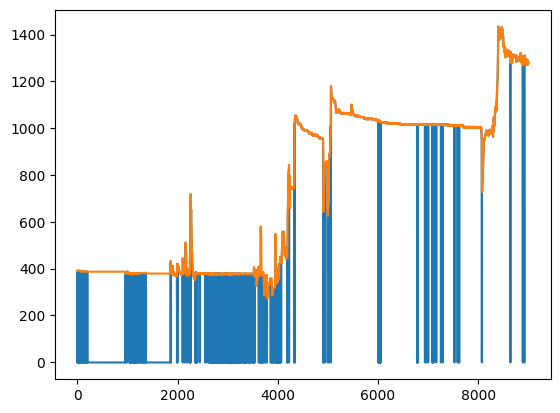

In [244]:
rr = np.fromfile(q[2], dtype=np.int32)
plt.plot(rr)
plt.plot(b[0])

In [271]:
m = Mapping(1920, 33, 2000., 7)
tv = m.convert_to_frequency(b[0].astype(int))

222
222
211


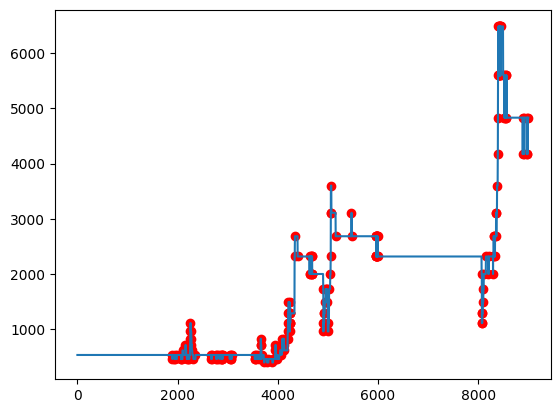

In [272]:
plt.plot(tv)
diff = np.diff(tv)
_i = np.where(diff != 0)[0] + 1
print(len(_i))
print(len(e[0]))
print(len(h[0]))
plt.scatter(_i, tv[_i], c="r")

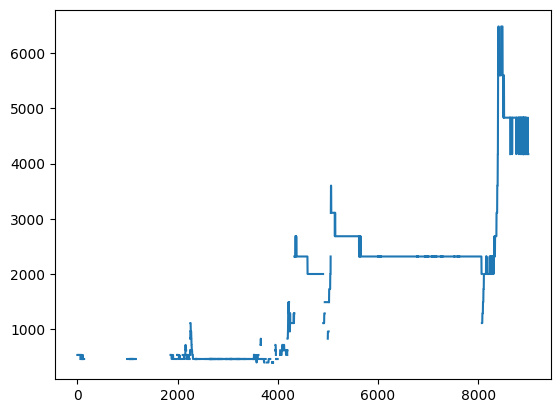

In [306]:
rr = np.fromfile(q[2], dtype=np.int32)
rr = rr.astype(float)
rr[np.equal(rr, -1)] = np.nan
# rr[rr == -1] = np.nan

tv = m.convert_to_frequency(rr)
plt.plot(tv)

In [260]:
def find_frequency_changes_with_nan(arr):
    _diff = np.diff(arr)
    condition = (~np.isnan(_diff)) & (_diff != 0)
    indices = np.where(condition)[0] + 1
    return arr[indices]

In [261]:
rr_switch = find_frequency_changes_with_nan(tv)

In [256]:
np.diff(tv)

array([nan, nan, nan, ...,  0.,  0.,  0.])

In [262]:
rr_switch


array([ 460.,  533.,  460.,  533.,  460.,  533.,  460.,  533.,  460.,
        533.,  460.,  533.,  533.,  617.,  715.,  617.,  460.,  533.,
        460.,  533.,  460.,  533.,  959.,  959.,  828.,  715.,  617.,
        533.,  460.,  533.,  460.,  533.,  533.,  460.,  533.,  460.,
        533.,  533.,  460.,  533.,  460.,  533.,  533.,  460.,  533.,
        460.,  533.,  460.,  533.,  460.,  533.,  460.,  533.,  828.,
        715.,  460.,  533.,  397.,  460.,  460.,  460.,  617.,  533.,
        617.,  715.,  828.,  715.,  617.,  715.,  617.,  715.,  828.,
        715.,  617.,  959., 1111., 1287., 1490., 1111., 1287., 1490.,
       1287., 1111.,  959., 1111., 1287., 1111., 1287., 2317., 2000.,
       2317., 2000., 2317., 2000., 2317., 2000., 2317., 2000., 1287.,
       1111., 1287., 1727., 1490., 1727., 1490., 1727., 1490., 1111.,
       2000., 2317., 3601., 3109., 2684., 3109., 2684., 2317., 2684.,
       2317., 2684., 2317., 2684., 2317., 2684., 2317., 2684., 2317.,
       2684., 2317.,

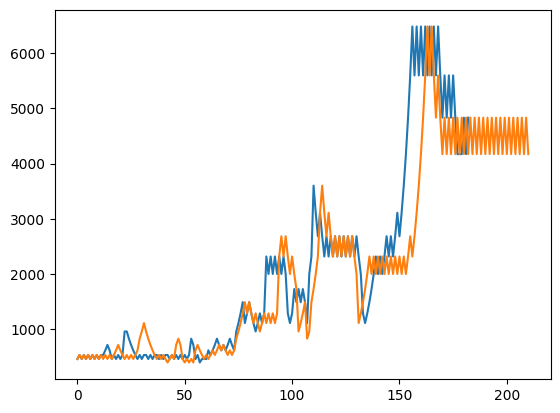

In [267]:
plt.plot(rr_switch)
plt.plot(h[0])

In [264]:
len(rr_switch)


183

In [265]:
len(b[0])

9000

In [266]:
len(h[0])

211

In [280]:
current_frequency = 533.0
sw = list()
for elt in rr:
    f = m.convert_position(elt)
    if f != current_frequency and f != -1:
        current_frequency = f
        sw.append(current_frequency)

In [281]:
len(sw)

222

In [282]:
len(h[0])

211

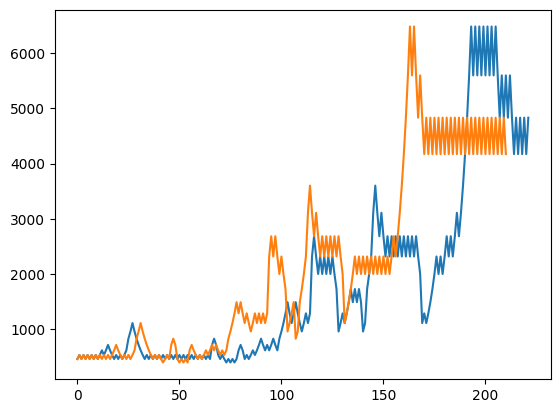

In [283]:
plt.plot(sw)
plt.plot(h[0])


In [279]:
sw[0]

533.0

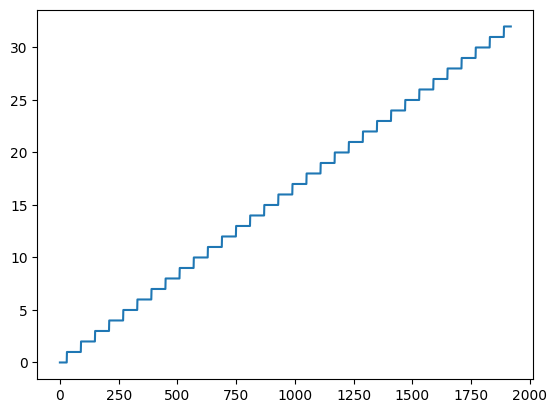

In [307]:
plt.plot(m._lut_indices)

In [285]:
np.unique(m._lut_indices, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([16, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 44]))